# 06. Transfer Learning with TensorFlow Part 3: Scaling up 扩大规模 (🍔👁 Food Vision mini)  

In the previous two notebooks ([transfer learning part 1: feature extraction](https://github.com/mrdbourke/tensorflow-deep-learning/blob/main/04_transfer_learning_in_tensorflow_part_1_feature_extraction.ipynb) and [part 2: fine-tuning](https://github.com/mrdbourke/tensorflow-deep-learning/blob/main/05_transfer_learning_in_tensorflow_part_2_fine_tuning.ipynb)) we've seen the power of transfer learning.

Now we know our smaller modelling experiments are working, it's time to step things up a notch with more data.

This is a common practice in machine learning and deep learning: get a model working on a small amount of data before scaling it up to a larger amount of data.

> 🔑 **Note:** You haven't forgotten the machine learning practitioners motto have you? "Experiment, experiment, experiment."

It's time to get closer to our Food Vision project coming to life. In this notebook we're going to scale up from using 10 classes of the Food101 data to using all of the classes in the Food101 dataset.

Our goal is to **beat the original [Food101 paper](https://data.vision.ee.ethz.ch/cvl/datasets_extra/food-101/static/bossard_eccv14_food-101.pdf)'s results with 10% of data**.

![](https://raw.githubusercontent.com/mrdbourke/tensorflow-deep-learning/main/images/06-ml-serial-experimentation.png)
*Machine learning practitioners are serial experimenters. Start small, get a model working, see if your experiments work then gradually scale them up to where you want to go (we're going to be looking at scaling up throughout this notebook).*

## What we're going to cover

We're going to go through the follow with TensorFlow:

- Downloading and preparing 10% of the Food101 data (10% of training data)
- Training a feature extraction transfer learning model on 10% of the Food101 training data
- Fine-tuning our feature extraction model
- Saving and loaded our trained model
- Evaluating the performance of our Food Vision model trained on 10% of the training data
  - Finding our model's most wrong predictions
- Making predictions with our Food Vision model on custom images of food

## How you can use this notebook

You can read through the descriptions and the code (it should all run, except for the cells which error on purpose), but there's a better option.

Write all of the code yourself.

Yes. I'm serious. Create a new notebook, and rewrite each line by yourself. Investigate it, see if you can break it, why does it break?

You don't have to write the text descriptions but writing the code yourself is a great way to get hands-on experience.

Don't worry if you make mistakes, we all do. The way to get better and make less mistakes is to **write more code**.

> 📖 **Resources:** 
> * See the full set of course materials on GitHub: https://github.com/mrdbourke/tensorflow-deep-learning
> * See updates for this notebook here: https://github.com/mrdbourke/tensorflow-deep-learning/discussions/549 

In [85]:
!nvidia-smi

/bin/bash: nvidia-smi: command not found


## Creating helper functions 导入函数

We've created a series of helper functions throughout the previous notebooks. Instead of rewriting them (tedious), we'll import the [`helper_functions.py`](https://github.com/mrdbourke/tensorflow-deep-learning/blob/main/extras/helper_functions.py) file from the GitHub repo.

In [86]:
# Get helper functions file
import os 
if not os.path.exists("helper_functions.py"):
    !wget https://raw.githubusercontent.com/mrdbourke/tensorflow-deep-learning/main/extras/helper_functions.py

In [87]:
from helper_functions import create_tensorboard_callback, plot_loss_curves, unzip_data, compare_historys, walk_through_dir

## 101 Food Classes: Working with less data

So far we've confirmed the transfer learning model's we've been using work pretty well with the 10 Food Classes dataset. Now it's time to step it up and see how they go with the full 101 Food Classes.

In the original [Food101](https://www.kaggle.com/dansbecker/food-101) dataset there's 1000 images per class (750 of each class in the training set and 250 of each class in the test set), totalling 101,000 imags.

We could start modelling straight away on this large dataset but in the spirit of continually experimenting, we're going to see how our previously working model's go with 10% of the training data.

This means for each of the 101 food classes we'll be building a model on 75 training images and evaluating it on 250 test images.


## Downloading and preprocessing the data

Just as before we'll download a subset of the Food101 dataset which has been extracted from the original dataset (to see the preprocessing of the data check out the [Food Vision preprocessing notebook](https://github.com/mrdbourke/tensorflow-deep-learning/blob/main/extras/image_data_modification.ipynb)).

We download the data as a zip file so we'll use our `unzip_data()` function to unzip it.

In [88]:
# Download data from Google Storage (already preformatted)
if os.path.exists("101_food_classes_10_percent"):
    print("Data already exists, skipping download...")
else:
    print("Downloading data...")
    !wget https://storage.googleapis.com/ztm_tf_course/food_vision/101_food_classes_10_percent.zip 

unzip_data("101_food_classes_10_percent.zip")

train_dir = "101_food_classes_10_percent/train/"
test_dir = "101_food_classes_10_percent/test/"

Data already exists, skipping download...


In [89]:
walk_through_dir("101_food_classes_10_percent")

There are 2 directories and 0 images in '101_food_classes_10_percent'.
There are 101 directories and 0 images in '101_food_classes_10_percent/train'.
There are 0 directories and 75 images in '101_food_classes_10_percent/train/dumplings'.
There are 0 directories and 75 images in '101_food_classes_10_percent/train/huevos_rancheros'.
There are 0 directories and 75 images in '101_food_classes_10_percent/train/croque_madame'.
There are 0 directories and 75 images in '101_food_classes_10_percent/train/paella'.
There are 0 directories and 75 images in '101_food_classes_10_percent/train/ceviche'.
There are 0 directories and 75 images in '101_food_classes_10_percent/train/clam_chowder'.
There are 0 directories and 75 images in '101_food_classes_10_percent/train/risotto'.
There are 0 directories and 75 images in '101_food_classes_10_percent/train/spaghetti_bolognese'.
There are 0 directories and 75 images in '101_food_classes_10_percent/train/fried_rice'.
There are 0 directories and 75 images in

Let's use the [`image_dataset_from_directory()`](https://www.tensorflow.org/api_docs/python/tf/keras/preprocessing/image_dataset_from_directory) function to turn our images and labels into a [`tf.data.Dataset`](https://www.tensorflow.org/api_docs/python/tf/data/Dataset), a TensorFlow datatype which allows for us to pass it directory to our model.

测试集，shuffle=False，对比不同模型的效果

For the test dataset, we're going to set `shuffle=False` so we can perform repeatable evaluation and visualization on it later.

In [90]:
# Setup data inputs
import tensorflow as tf
IMG_SIZE = (224, 224)
train_data_all_10_percent = tf.keras.preprocessing.image_dataset_from_directory(train_dir,
                                                                                label_mode="categorical",
                                                                                image_size=IMG_SIZE)
                                                                                
test_data = tf.keras.preprocessing.image_dataset_from_directory(test_dir,
                                                                label_mode="categorical",
                                                                image_size=IMG_SIZE,
                                                                shuffle=False) # don't shuffle test data for prediction analysis

Found 7575 files belonging to 101 classes.
Found 25250 files belonging to 101 classes.


Wonderful! It looks like our data has been imported as expected with 75 images per class in the training set (75 images * 101 classes = 7575 images) and 25250 images in the test set (250 images * 101 classes = 25250 images). 


## Train a big dog model with transfer learning on 10% of 101 food classes

Our food image data has been imported into TensorFlow, time to model it.

To keep our experiments swift, we're going to start by using feature extraction transfer learning with a pre-trained model for a few epochs and then fine-tune for a few more epochs.‘

步骤：1、model checkpoint，作为模型保存点的callback，2、数据增强，3、EfficientNetB0基础模型，4、添加Dense层，5、loss函数，6、adam优化器，7、15%的数据模型训练

More specifically, our goal will be to see if we can beat the baseline from original [Food101 paper](https://data.vision.ee.ethz.ch/cvl/datasets_extra/food-101/static/bossard_eccv14_food-101.pdf) (50.76% accuracy on 101 classes) with 10% of the training data and the following modelling setup:
* A [`ModelCheckpoint`](https://www.tensorflow.org/api_docs/python/tf/keras/callbacks/ModelCheckpoint) callback to save our progress during training, this means we could experiment with further training later without having to train from scratch every time
* Data augmentation built right into the model
* A headless (no top layers) [`EfficientNetB0`](https://www.tensorflow.org/api_docs/python/tf/keras/applications/EfficientNetB0) architecture from `tf.keras.applications` as our base model
* A `Dense` layer with 101 hidden neurons (same as number of food classes) and softmax activation as the output layer
* Categorical crossentropy as the loss function since we're dealing with more than two classes
* The Adam optimizer with the default settings
* Fitting for 5 full passes on the training data while evaluating on 15% of the test data

It seems like a lot but these are all things we've covered before in the [Transfer Learning in TensorFlow Part 2: Fine-tuning notebook](https://github.com/mrdbourke/tensorflow-deep-learning/blob/main/05_transfer_learning_in_tensorflow_part_2_fine_tuning.ipynb).

Let's start by creating the `ModelCheckpoint` callback. 

Since we want our model to perform well on unseen data we'll set it to monitor the validation accuracy metric and save the model weights which score the best on that.

In [91]:
checkpoint_path = "101_classes_10_percent_data_model_checkpoint"
# save only the model weights, save the model weights which score the best validation accuracy,# only keep the best model weights on file (delete the rest)
checkpoint_callback = tf.keras.callbacks.ModelCheckpoint(filepath=checkpoint_path,
                                                     save_weights_only=True,
                                                     monitor="val_accuracy",
                                                     save_best_only=True)

In [92]:
from tensorflow.keras import layers
from tensorflow.keras.models import Sequential

# 使用tensorflow的数据增强
data_augmentation = Sequential([
  layers.RandomFlip("horizontal"),
  layers.RandomRotation(0.2),
  layers.RandomZoom(0.2),
  layers.RandomHeight(0.2),
  layers.RandomWidth(0.2),
  # preprocessing.Rescaling(1./255) # keep for ResNet50V2, remove for EfficientNetB0
], name ="data_augmentation")

In [93]:
# 导入EfficientNetB0作为基座模型，并设置include_top=False，方便后续添加top层dense层
base_model = tf.keras.applications.EfficientNetB0(include_top=False)
base_model.trainable = False

# 添加输入层
inputs = tf.keras.Input(shape=(224, 224, 3))
x = data_augmentation(inputs)
x = base_model(x, training=False)
x = layers.GlobalAveragePooling2D(name="global_average_pooling")(x)
outputs = layers.Dense(len(train_data_all_10_percent.class_names), activation="softmax", name="output")(x)
model = tf.keras.Model(inputs, outputs)

![](https://raw.githubusercontent.com/mrdbourke/tensorflow-deep-learning/main/images/06-efficientnetb0-feature-extractor-with-dense-layer-on-top.png)
*A colourful figure of the model we've created with: 224x224 images as input, data augmentation as a layer, EfficientNetB0 as a backbone, an averaging pooling layer as well as dense layer with 10 neurons (same as number of classes we're working with) as output.*

Model created. Let's inspect it.

In [94]:
model.summary()

Model: "model_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_8 (InputLayer)        [(None, 224, 224, 3)]     0         
                                                                 
 data_augmentation (Sequenti  (None, None, None, 3)    0         
 al)                                                             
                                                                 
 efficientnetb0 (Functional)  (None, None, None, 1280)  4049571  
                                                                 
 global_average_pooling (Glo  (None, 1280)             0         
 balAveragePooling2D)                                            
                                                                 
 output (Dense)              (None, 101)               129381    
                                                                 
Total params: 4,178,952
Trainable params: 129,381
Non-train

Looking good! Our Functional model has 5 layers but each of those layers have varying amounts of layers within them.

Notice the number of trainable and non-trainable parameters. It seems the only trainable parameters are within the `output_layer` which is exactly what we're after with this first run of feature extraction; keep all the learned patterns in the base model (`EfficientNetb0`) frozen whilst allowing the model to tune its outputs to our custom data.

保持基础模型参数冻结，只训练输出层。

Time to compile and fit.

In [95]:
model.compile(loss='categorical_crossentropy',
              optimizer=tf.keras.optimizers.Adam(),
              metrics=['accuracy'])
history_all_classes_10_percent = model.fit(train_data_all_10_percent,
                    epochs=5,
                    validation_data=test_data,
                    validation_steps=int(0.15 * len(test_data)),
                    callbacks=[checkpoint_callback])

Epoch 1/5
237/237 [==============================] - 131s 540ms/step - loss: 3.4808 - accuracy: 0.2458 - val_loss: 2.7052 - val_accuracy: 0.4036
Epoch 2/5
237/237 [==============================] - 126s 533ms/step - loss: 2.3485 - accuracy: 0.4628 - val_loss: 2.2181 - val_accuracy: 0.4740
Epoch 3/5
237/237 [==============================] - 128s 541ms/step - loss: 1.9694 - accuracy: 0.5274 - val_loss: 2.0774 - val_accuracy: 0.4876
Epoch 4/5
237/237 [==============================] - 126s 530ms/step - loss: 1.7625 - accuracy: 0.5690 - val_loss: 1.9796 - val_accuracy: 0.4989
Epoch 5/5
237/237 [==============================] - 125s 527ms/step - loss: 1.5918 - accuracy: 0.6116 - val_loss: 1.9255 - val_accuracy: 0.5045


In [96]:
results_feature_extraction_model = model.evaluate(test_data)
results_feature_extraction_model

 44/790 [>.............................] - ETA: 4:00 - loss: 2.1402 - accuracy: 0.4503

790/790 [==============================] - 258s 326ms/step - loss: 1.6911 - accuracy: 0.5620


[1.6911349296569824, 0.5619801878929138]

<Axes: >

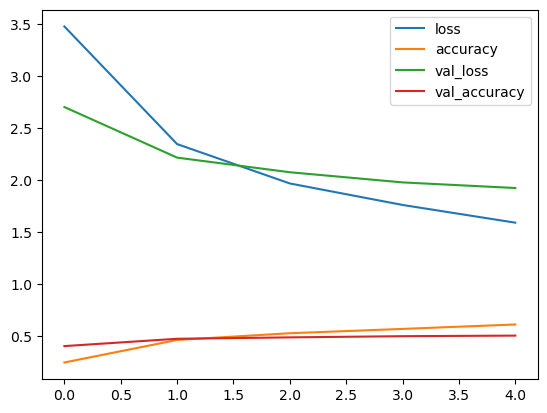

In [97]:
import pandas as pd
pd.DataFrame(history_all_classes_10_percent.history).plot()

> 🤔 **Question:** What do these curves suggest? Hint: ideally, the two curves should be very similar to each other, if not, there may be some overfitting or underfitting.

### Fine-tuning

Our feature extraction transfer learning model is performing well. Why don't we try to fine-tune a few layers in the base model and see if we gain any improvements?

The good news is, thanks to the `ModelCheckpoint` callback, we've got the saved weights of our already well-performing model so if fine-tuning doesn't add any benefits, we can revert back.

To fine-tune the base model we'll first set its `trainable` attribute to `True`, unfreezing all of the frozen.

Then since we've got a relatively small training dataset, we'll refreeze every layer except for the last 5, making them trainable.

In [98]:
base_model.trainable = True

# Refreeze every layer except for the last 5
for layer in base_model.layers[:-5]:
  layer.trainable = False

We just made a change to the layers in our model and what do we have to do every time we make a change to our model?

Recompile it.

Because we're fine-tuning, we'll use a 10x lower learning rate to ensure the updates to the previous trained weights aren't too large.

![](https://raw.githubusercontent.com/mrdbourke/tensorflow-deep-learning/main/images/06-lowering-the-learning-rate.png)
*When fine-tuning and unfreezing layers of your pre-trained model, it's common practice to lower the learning rate you used for your feature extraction model. How much by? A 10x lower learning rate is usually a good place to to start.*

In [99]:
model.compile(loss='categorical_crossentropy', optimizer=tf.keras.optimizers.Adam(learning_rate=0.0001), metrics=['accuracy'])

In [100]:
for layer in model.layers:
  print(layer.name, layer.trainable)

input_8 True
data_augmentation True
efficientnetb0 True
global_average_pooling True
output True


In [101]:
for layer_number, layer in enumerate(base_model.layers):
  print(layer_number, layer.name, layer.trainable)

0 input_7 False
1 rescaling_3 False
2 normalization_3 False
3 stem_conv_pad False
4 stem_conv False
5 stem_bn False
6 stem_activation False
7 block1a_dwconv False
8 block1a_bn False
9 block1a_activation False
10 block1a_se_squeeze False
11 block1a_se_reshape False
12 block1a_se_reduce False
13 block1a_se_expand False
14 block1a_se_excite False
15 block1a_project_conv False
16 block1a_project_bn False
17 block2a_expand_conv False
18 block2a_expand_bn False
19 block2a_expand_activation False
20 block2a_dwconv_pad False
21 block2a_dwconv False
22 block2a_bn False
23 block2a_activation False
24 block2a_se_squeeze False
25 block2a_se_reshape False
26 block2a_se_reduce False
27 block2a_se_expand False
28 block2a_se_excite False
29 block2a_project_conv False
30 block2a_project_bn False
31 block2b_expand_conv False
32 block2b_expand_bn False
33 block2b_expand_activation False
34 block2b_dwconv False
35 block2b_bn False
36 block2b_activation False
37 block2b_se_squeeze False
38 block2b_se_resha

Excellent! Time to fine-tune our model.

Another 5 epochs should be enough to see whether any benefits come about (though we could always try more).

We'll start the training off where the feature extraction model left off using the `initial_epoch` parameter in the `fit()` function.

In [102]:
# initial_epoch,使用initial_epoch=history_all_classes_10_percent.epoch[-1],接着特征抽取的模型继续训练，原来5轮，再训练5轮，共10轮

fine_tune_epochs = 10

history_all_classes_10_percent_fine_tune = model.fit(train_data_all_10_percent,
                    epochs=fine_tune_epochs,
                    validation_data=test_data,
                    validation_steps=int(0.15 * len(test_data)),
                    initial_epoch=history_all_classes_10_percent.epoch[-1],)

Epoch 5/10
139/237 [================>.............] - ETA: 37s - loss: 1.3735 - accuracy: 0.6551

237/237 [==============================] - 133s 550ms/step - loss: 1.3489 - accuracy: 0.6540 - val_loss: 1.9250 - val_accuracy: 0.5008
Epoch 6/10
237/237 [==============================] - 128s 540ms/step - loss: 1.2281 - accuracy: 0.6771 - val_loss: 1.8815 - val_accuracy: 0.5106
Epoch 7/10
237/237 [==============================] - 128s 541ms/step - loss: 1.1537 - accuracy: 0.6969 - val_loss: 1.9298 - val_accuracy: 0.4989
Epoch 8/10
237/237 [==============================] - 128s 540ms/step - loss: 1.0920 - accuracy: 0.7109 - val_loss: 1.8696 - val_accuracy: 0.5130
Epoch 9/10
237/237 [==============================] - 124s 524ms/step - loss: 1.0352 - accuracy: 0.7248 - val_loss: 1.9360 - val_accuracy: 0.5016
Epoch 10/10
237/237 [==============================] - 124s 525ms/step - loss: 0.9857 - accuracy: 0.7368 - val_loss: 1.8912 - val_accuracy: 0.5090


In [103]:
results_all_classes_10_percent_fine_tune = model.evaluate(test_data)
results_all_classes_10_percent_fine_tune

 37/790 [>.............................] - ETA: 3:53 - loss: 2.2213 - accuracy: 0.4493

790/790 [==============================] - 247s 312ms/step - loss: 1.5880 - accuracy: 0.5815


[1.5880355834960938, 0.5815445780754089]

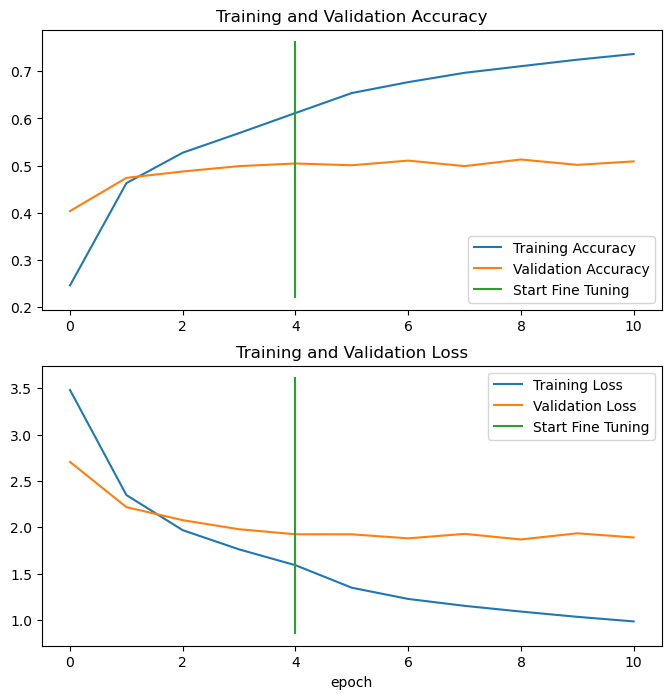

In [104]:
compare_historys(original_history=history_all_classes_10_percent,
                 new_history=history_all_classes_10_percent_fine_tune,
                 initial_epochs=5)

fine-tuning.模型很容易过拟合了，在预训练模型的数据集和微调数据集比较接近的时候，更容易过拟合

It seems that after fine-tuning, our model's training metrics improved significantly but validation, not so much. Looks like our model is starting to overfit. 

This is okay though, its very often the case that fine-tuning leads to overfitting when the data a pre-trained model has been trained on is similar to your custom data.

In our case, our pre-trained model, `EfficientNetB0` was trained on [ImageNet](http://www.image-net.org/index) which contains many real life pictures of food just like our food dataset.

If feautre extraction already works well, the improvements you see from fine-tuning may not be as great as if your dataset was significantly different from the data your base model was pre-trained on.

### Saving our trained model

To prevent having to retrain our model from scratch, let's save it to file using the [`save()`](https://www.tensorflow.org/api_docs/python/tf/keras/Model#save) method.

In [105]:
# 模型包含不可序列化的对象，
# model.save("drive/My Drive/tensorflow_course/101_food_class_10_percent_saved_big_dog_model")

## Evaluating the performance of the big dog model across all different classes  评估模型

We've got a trained and saved model which according to the evaluation metrics we've used is performing fairly well.

But metrics schmetrics, let's dive a little deeper into our model's performance and get some visualizations going.

To do so, we'll load in the saved model and use it to make some predictions on the test dataset.

> 🔑 **Note:** Evaluating a machine learning model is as important as training one. Metrics can be deceiving. You should always visualize your model's performance on unseen data to make sure you aren't being fooled good looking training numbers.

In [106]:
import tensorflow as tf

if not os.path.exists("06_101_food_class_10_percent_saved_big_dog_model"):
    !wget https://storage.googleapis.com/ztm_tf_course/food_vision/06_101_food_class_10_percent_saved_big_dog_model.zip
saved_model_path = "06_101_food_class_10_percent_saved_big_dog_model.zip"
if not os.path.exists("101_food_classes_10_percent"):
    unzip_data(saved_model_path)

--2025-01-14 18:22:09--  https://storage.googleapis.com/ztm_tf_course/food_vision/06_101_food_class_10_percent_saved_big_dog_model.zip
Resolving storage.googleapis.com (storage.googleapis.com)... 142.250.217.123, 142.251.33.123, 142.251.215.251, ...
Connecting to storage.googleapis.com (storage.googleapis.com)|142.250.217.123|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 46760742 (45M) [application/zip]
Saving to: ‘06_101_food_class_10_percent_saved_big_dog_model.zip.1’

6_101_food_class_10  29%[====>               ]  13.13M  5.76MB/s               

06_101_food_class_1 100%[===================>]  44.59M  11.0MB/s    in 4.4s    

2025-01-14 18:22:15 (10.1 MB/s) - ‘06_101_food_class_10_percent_saved_big_dog_model.zip.1’ saved [46760742/46760742]



In [107]:
loaded_loss, loaded_accuracy = model.evaluate(test_data)
loaded_loss, loaded_accuracy

186/790 [======>.......................] - ETA: 3:07 - loss: 1.8543 - accuracy: 0.5101

790/790 [==============================] - 246s 312ms/step - loss: 1.5880 - accuracy: 0.5815


(1.5880355834960938, 0.5815445780754089)

### Making predictions with our trained model

To evaluate our trained model, we need to make some predictions with it and then compare those predictions to the test dataset.

Because the model has never seen the test dataset, this should give us an indication of how the model will perform in the real world on data similar to what it has been trained on.

To make predictions with our trained model, we can use the `predict()` method passing it the test data.

Since our data is multi-class, doing this will return a prediction probably tensor for each sample.

In other words, every time the trained model see's an image it will compare it to all of the patterns it learned during training and return an output for every class (all 101 of them) of how likely the image is to be that class.

In [108]:
pred_probs = model.predict(test_data, verbose=1) 

161/790 [=====>........................] - ETA: 3:17

790/790 [==============================] - 250s 316ms/step


In [109]:
len(pred_probs),pred_probs.shape

(25250, (25250, 101))

In [110]:
pred_probs[:10]

array([[4.5324820e-01, 3.1342378e-04, 7.5825185e-02, ..., 2.4751867e-05,
        1.6623468e-03, 3.5077412e-02],
       [8.5508728e-01, 5.5006399e-07, 1.9797396e-03, ..., 1.7567175e-03,
        7.6747307e-07, 5.7889524e-06],
       [4.0673810e-01, 5.7166652e-03, 1.2998066e-02, ..., 3.3316325e-04,
        1.7075837e-03, 3.3460264e-03],
       ...,
       [2.7706563e-01, 1.5258461e-05, 1.0957072e-03, ..., 6.0276151e-02,
        4.5795707e-04, 1.9038084e-04],
       [2.4135877e-01, 1.0972233e-03, 7.3732004e-02, ..., 3.6604117e-04,
        7.8709490e-05, 7.4014376e-04],
       [4.5308498e-01, 5.2757259e-06, 1.3420847e-03, ..., 1.5670722e-02,
        2.1571495e-05, 3.4528470e-03]], dtype=float32)

In [111]:
print(f"预测的可能性数量：{len(pred_probs[0])}")
print(f"预测的值，一个样本：{pred_probs[0]}")
print(f"预测的值，一个样本,最大的可能性的下标：{pred_probs[0].argmax()}")

预测的可能性数量：101
预测的值，一个样本：[4.5324820e-01 3.1342378e-04 7.5825185e-02 2.2844853e-08 1.7318440e-05
 8.5779520e-06 1.6669862e-04 7.1396616e-06 3.4421630e-02 5.0043536e-04
 2.9605790e-06 1.2374193e-05 1.9091242e-03 4.8744221e-07 2.2742687e-02
 1.5553092e-03 2.2840359e-05 4.6901699e-04 3.0272878e-03 2.8772877e-06
 1.6982346e-04 4.5443536e-05 7.8368542e-04 1.4039520e-04 5.3614785e-04
 3.3522045e-04 4.9752020e-04 1.5022348e-05 6.0723029e-02 4.9073710e-03
 3.5912080e-06 2.4296930e-03 1.5113757e-03 2.9778676e-07 1.0434766e-02
 2.3790633e-05 3.7036155e-04 7.2098710e-04 2.7557978e-02 1.5777283e-05
 7.1342778e-04 8.3549868e-04 2.0406635e-03 2.4590276e-05 3.9835206e-05
 3.1106731e-05 1.2386271e-03 4.4657133e-04 1.9434922e-06 2.0175457e-02
 8.1889500e-04 2.9016264e-05 9.9182099e-02 3.0304797e-03 5.6563651e-05
 4.7927171e-02 1.6085124e-02 1.6901005e-03 3.9337971e-03 9.0067151e-05
 1.3568797e-06 8.1391982e-04 1.1444534e-02 7.6068412e-05 6.9492584e-05
 2.7851827e-04 2.4363571e-05 5.0241053e-03 1.4888225e-

> 🔑 **Note:** Due to the nature of the softmax activation function, the sum of each of the prediction probabilities for a single sample will be 1 (or at least very close to 1). E.g. `pred_probs[0].sum() = 1`.

We can find the index of the maximum value in each prediction probability tensor using the `argmax()` method.

softmax,将多分类的预测值归一，然后获取最大可能性的下标

In [112]:
pred_classes = pred_probs.argmax(axis=1)
pred_classes[:10]

array([ 0,  0,  0,  8, 29, 78, 29, 46,  9,  0])

In [113]:
y_labels =[]
# test_data,数据加载器，需要unbatch()testdata
for image, label in test_data.unbatch():
    y_labels.append(label.numpy().argmax())
y_labels[:10]

[0, 0, 0, 0, 0, 0, 0, 0, 0, 0]

In [114]:
len(y_labels)

25250

### Evaluating our models predictions 模型评估

A very simple evaluation is to use Scikit-Learn's [`accuracy_score()`](https://scikit-learn.org/stable/modules/generated/sklearn.metrics.accuracy_score.html) function which compares truth labels to predicted labels and returns an accuracy score.

If we've created our `y_labels` and `pred_classes` arrays correctly, this should return the same accuracy value (or at least very close) as the `evaluate()` method we used earlier.

In [115]:
from sklearn.metrics import accuracy_score
sklearn_accuracy = accuracy_score(y_labels, pred_classes)
sklearn_accuracy

0.5815445544554455

In [116]:
loaded_accuracy

0.5815445780754089

In [117]:
from helper_functions import make_confusion_matrix

In [118]:
import itertools
import matplotlib.pyplot as plt
import numpy as np
from sklearn.metrics import confusion_matrix


def make_confusion_matrix(y_true, y_pred, classes=None, figsize=(10, 10), text_size=15, norm=False, savefig=False): 
  """Makes a labelled confusion matrix comparing predictions and ground truth labels.

  If classes is passed, confusion matrix will be labelled, if not, integer class values
  will be used.

  Args:
    y_true: Array of truth labels (must be same shape as y_pred).
    y_pred: Array of predicted labels (must be same shape as y_true).
    classes: Array of class labels (e.g. string form). If `None`, integer labels are used.
    figsize: Size of output figure (default=(10, 10)).
    text_size: Size of output figure text (default=15).
    norm: normalize values or not (default=False).
    savefig: save confusion matrix to file (default=False).
  
  Returns:
    A labelled confusion matrix plot comparing y_true and y_pred.

  Example usage:
    make_confusion_matrix(y_true=test_labels, # ground truth test labels
                          y_pred=y_preds, # predicted labels
                          classes=class_names, # array of class label names
                          figsize=(15, 15),
                          text_size=10)
  """  
  # Create the confustion matrix
  cm = confusion_matrix(y_true, y_pred)
  cm_norm = cm.astype("float") / cm.sum(axis=1)[:, np.newaxis] # normalize it
  n_classes = cm.shape[0] # find the number of classes we're dealing with

  # Plot the figure and make it pretty
  fig, ax = plt.subplots(figsize=figsize)
  cax = ax.matshow(cm, cmap=plt.cm.Blues) # colors will represent how 'correct' a class is, darker == better
  fig.colorbar(cax)

  # Are there a list of classes?
  if classes:
    labels = classes
  else:
    labels = np.arange(cm.shape[0])
  
  # Label the axes
  ax.set(title="Confusion Matrix",
         xlabel="Predicted label",
         ylabel="True label",
         xticks=np.arange(n_classes), # create enough axis slots for each class
         yticks=np.arange(n_classes), 
         xticklabels=labels, # axes will labeled with class names (if they exist) or ints
         yticklabels=labels)
  
  # Make x-axis labels appear on bottom
  ax.xaxis.set_label_position("bottom")
  ax.xaxis.tick_bottom()

  ### Added: Rotate xticks for readability & increase font size (required due to such a large confusion matrix)
  plt.xticks(rotation=70, fontsize=text_size)
  plt.yticks(fontsize=text_size)

  # Set the threshold for different colors
  threshold = (cm.max() + cm.min()) / 2.

  # Plot the text on each cell
  for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
    if norm:
      plt.text(j, i, f"{cm[i, j]} ({cm_norm[i, j]*100:.1f}%)",
              horizontalalignment="center",
              color="white" if cm[i, j] > threshold else "black",
              size=text_size)
    else:
      plt.text(j, i, f"{cm[i, j]}",
              horizontalalignment="center",
              color="white" if cm[i, j] > threshold else "black",
              size=text_size)

  # Save the figure to the current working directory
  if savefig:
    fig.savefig("confusion_matrix.png")

In [119]:
class_names = test_data.class_names
class_names[:10]

['apple_pie',
 'baby_back_ribs',
 'baklava',
 'beef_carpaccio',
 'beef_tartare',
 'beet_salad',
 'beignets',
 'bibimbap',
 'bread_pudding',
 'breakfast_burrito']

In [120]:
make_confusion_matrix(y_true=y_labels,
                      y_pred=pred_classes,
                      classes=class_names,
                      figsize=(100, 100),
                      text_size=20,
                      norm=False,
                      savefig=True)

In [121]:
from sklearn.metrics import classification_report
print(classification_report(y_labels, pred_classes))

              precision    recall  f1-score   support

           0       0.34      0.12      0.17       250
           1       0.50      0.68      0.57       250
           2       0.70      0.52      0.59       250
           3       0.80      0.51      0.62       250
           4       0.54      0.42      0.47       250
           5       0.45      0.29      0.35       250
           6       0.73      0.75      0.74       250
           7       0.85      0.67      0.75       250
           8       0.25      0.51      0.34       250
           9       0.42      0.64      0.51       250
          10       0.47      0.46      0.46       250
          11       0.74      0.55      0.63       250
          12       0.72      0.56      0.63       250
          13       0.53      0.52      0.53       250
          14       0.54      0.47      0.50       250
          15       0.34      0.33      0.33       250
          16       0.66      0.52      0.58       250
          17       0.39    

In [122]:
# output_dict 设置，输出格式为dict，字典，方便后续操作
classification_report_dict = classification_report(y_labels, pred_classes, output_dict=True)
classification_report_dict

{'0': {'precision': 0.3372093023255814,
  'recall': 0.116,
  'f1-score': 0.17261904761904762,
  'support': 250.0},
 '1': {'precision': 0.5,
  'recall': 0.676,
  'f1-score': 0.5748299319727891,
  'support': 250.0},
 '2': {'precision': 0.7010869565217391,
  'recall': 0.516,
  'f1-score': 0.5944700460829493,
  'support': 250.0},
 '3': {'precision': 0.7987421383647799,
  'recall': 0.508,
  'f1-score': 0.6210268948655256,
  'support': 250.0},
 '4': {'precision': 0.5384615384615384,
  'recall': 0.42,
  'f1-score': 0.47191011235955055,
  'support': 250.0},
 '5': {'precision': 0.4528301886792453,
  'recall': 0.288,
  'f1-score': 0.35207823960880197,
  'support': 250.0},
 '6': {'precision': 0.73046875,
  'recall': 0.748,
  'f1-score': 0.7391304347826086,
  'support': 250.0},
 '7': {'precision': 0.8527918781725888,
  'recall': 0.672,
  'f1-score': 0.7516778523489933,
  'support': 250.0},
 '8': {'precision': 0.25098039215686274,
  'recall': 0.512,
  'f1-score': 0.3368421052631579,
  'support': 25

The `classification_report()` outputs the precision, recall and f1-score's per class.

A reminder:
* **Precision** - Proportion of true positives over total number of samples. Higher precision leads to less false positives (model predicts 1 when it should've been 0).
* **Recall** - Proportion of true positives over total number of true positives and false negatives (model predicts 0 when it should've been 1). Higher recall leads to less false negatives.
* **F1 score** - Combines precision and recall into one metric. 1 is best, 0 is worst.

The above output is helpful but with so many classes, it's a bit hard to understand.

Let's see if we make it easier with the help of a visualization.

First, we'll get the output of `classification_report()` as a dictionary by setting `output_dict=True`.

In [123]:
class_f1_scores = {}
# Loop through classification report items
for k, v in classification_report_dict.items():
  if k == "accuracy": # stop once we get to accuracy key
    break
  else:
    # Append class names and f1-scores to new dictionary
    class_f1_scores[class_names[int(k)]] = v["f1-score"]
class_f1_scores

{'apple_pie': 0.17261904761904762,
 'baby_back_ribs': 0.5748299319727891,
 'baklava': 0.5944700460829493,
 'beef_carpaccio': 0.6210268948655256,
 'beef_tartare': 0.47191011235955055,
 'beet_salad': 0.35207823960880197,
 'beignets': 0.7391304347826086,
 'bibimbap': 0.7516778523489933,
 'bread_pudding': 0.3368421052631579,
 'breakfast_burrito': 0.5111111111111111,
 'bruschetta': 0.46153846153846156,
 'caesar_salad': 0.631336405529954,
 'cannoli': 0.6306306306306306,
 'caprese_salad': 0.5282258064516129,
 'carrot_cake': 0.5,
 'ceviche': 0.3346938775510204,
 'cheese_plate': 0.5822222222222222,
 'cheesecake': 0.3929273084479371,
 'chicken_curry': 0.45746691871455575,
 'chicken_quesadilla': 0.5952380952380952,
 'chicken_wings': 0.6833631484794276,
 'chocolate_cake': 0.5391969407265774,
 'chocolate_mousse': 0.3372093023255814,
 'churros': 0.731006160164271,
 'clam_chowder': 0.6787878787878788,
 'club_sandwich': 0.6813186813186813,
 'crab_cakes': 0.3675889328063241,
 'creme_brulee': 0.72577319

In [124]:
f1_scores = pd.DataFrame({"class_name":list(class_f1_scores.keys()),"f1_score":class_f1_scores.values()})
f1_scores.sort_values(by="f1_score",ascending=False)
f1_scores.head()

class_name  f1_score
0       apple_pie  0.172619
1  baby_back_ribs  0.574830
2         baklava  0.594470
3  beef_carpaccio  0.621027
4    beef_tartare  0.471910

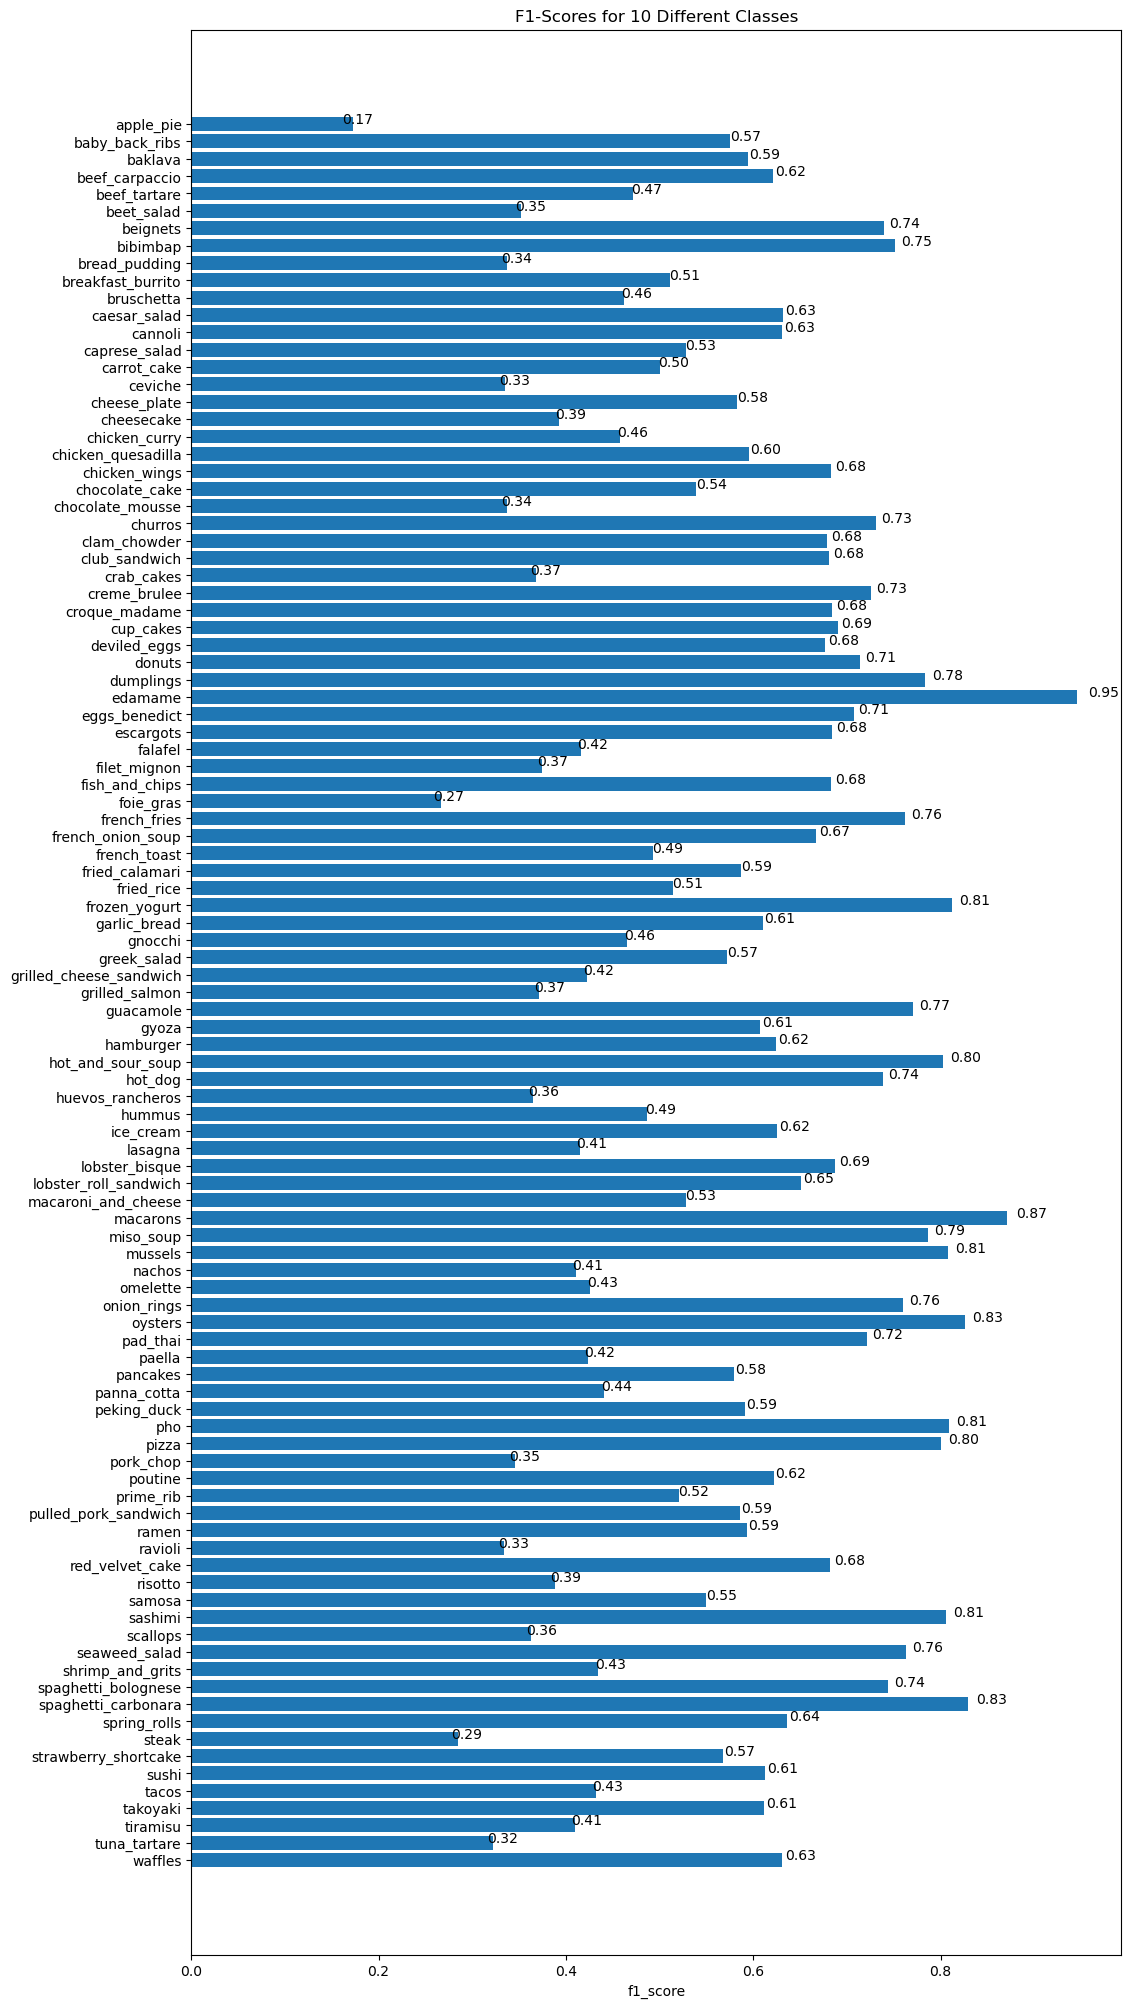

In [125]:
import matplotlib.pyplot as plt

fig, ax = plt.subplots(figsize=(12, 25))
scores = ax.barh(range(len(f1_scores)), f1_scores["f1_score"].values)
ax.set_yticks(range(len(f1_scores)))
ax.set_yticklabels(list(f1_scores["class_name"]))
ax.set_xlabel("f1_score")
ax.set_title("F1-Scores for 10 Different Classes")
ax.invert_yaxis(); # reverse the order

def autolabel(rects): # Modified version of: https://matplotlib.org/examples/api/barchart_demo.html
  """
  Attach a text label above each bar displaying its height (it's value).
  """
  for rect in rects:
    width = rect.get_width()
    ax.text(1.03*width, rect.get_y() + rect.get_height()/1.5,
            f"{width:.2f}",
            ha='center', va='bottom')

autolabel(scores)

除了acc，F1更适合排序模型，因为F1值越大，模型预测的准确率越高。auc和pcoc更适合广告ctr、cvr模型，不仅看顺序，还要看预测的准确率。

### Visualizing predictions on test images  测试集可视化预测结果

Time for the real test. Visualizing predictions on actual images. You can look at all the metrics you want but until you've visualized some predictions, you won't really know how your model is performing.

As it stands, our model can't just predict on any image of our choice. The image first has to be loaded into a tensor.

So to begin predicting on any given image, we'll create a function to load an image into a tensor.

tf.io.read_file()读取文件，tf.io.decode_image()转变为tensor，resize，数值归一化

Specifically, it'll:
* Read in a target image filepath using [`tf.io.read_file()`](https://www.tensorflow.org/api_docs/python/tf/io/read_file).
* Turn the image into a `Tensor` using [`tf.io.decode_image()`](https://www.tensorflow.org/api_docs/python/tf/io/decode_image).
* Resize the image to be the same size as the images our model has been trained on (224 x 224) using [`tf.image.resize()`](https://www.tensorflow.org/api_docs/python/tf/image/resize).
* Scale the image to get all the pixel values between 0 & 1 if necessary.

In [126]:
def load_and_prep_image(filename, img_shape=224, scale=True):
  """
  Reads in an image from filename, turns it into a tensor and reshapes into
  (224, 224, 3).

  Parameters
  ----------
  filename (str): string filename of target image
  img_shape (int): size to resize target image to, default 224
  scale (bool): whether to scale pixel values to range(0, 1), default True
  """
  img = tf.io.read_file(filename)
  img = tf.image.decode_jpeg(img)
  img = tf.image.resize(img, [img_shape, img_shape])
  if scale:
    return img/255.
  else:
    return img

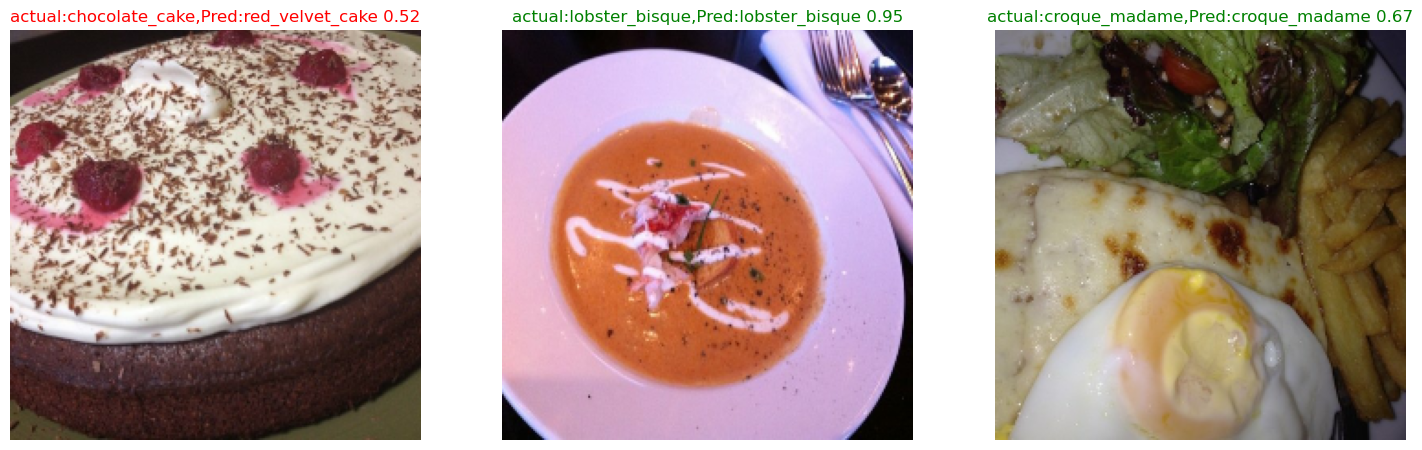

In [127]:
import os,random

plt.figure(figsize=(18,10))

for i in range(3):
    class_name = random.choice(class_names)
    filename = random.choice(os.listdir(f"{test_dir}/{class_name}"))
    filepath = os.path.join(test_dir,class_name,filename)
    
    img = load_and_prep_image(filepath,scale=False)
    pred_prob = model.predict(tf.expand_dims(img,axis=0))
    # print(f"pred_prob:{pred_prob}")
    pred_class = class_names[int(pred_prob.argmax())]
    
    # Plot image and prediction
    plt.subplot(1,3,i+1)
    plt.imshow(img/255)
    if class_name == pred_class:
        color = "green"
    else:
        color = "red"
    plt.title(f"actual:{class_name},Pred:{pred_class} {pred_prob.max():.2f}",color=color)
    plt.axis(False)

### Finding the most wrong predictions 找到错的最离谱的图片

It's a good idea to go through at least 100+ random instances of your model's predictions to get a good feel for how it's doing.

After a while you might notice the model predicting on some images with a very high prediction probability, meaning it's very confident with its prediction but still getting the label wrong.

These **most wrong** predictions can help to give further insight into your model's performance.

So how about we write some code to collect all of the predictions where the model has output a high prediction probability for an image (e.g. 0.95+) but gotten the prediction wrong.

We'll go through the following steps:
1. Get all of the image file paths in the test dataset using the [`list_files()`](https://www.tensorflow.org/api_docs/python/tf/data/Dataset#list_files) method.
2. Create a pandas DataFrame of the image filepaths, ground truth labels, prediction classes, max prediction probabilities, ground truth class names and predicted class names.
  * **Note:** We don't necessarily have to create a DataFrame like this but it'll help us visualize things as we go.
3. Use our DataFrame to find all the wrong predictions (where the ground truth doesn't match the prediction).
4. Sort the DataFrame based on wrong predictions and highest max prediction probabilities.
5. Visualize the images with the highest prediction probabilities but have the wrong prediction.

In [128]:
filepaths = []
for filepath in test_data.list_files("101_food_classes_10_percent/test/*/*.jpg", shuffle=False):
    filepaths.append(filepath.numpy())
filepaths[:5]

[b'101_food_classes_10_percent/test/apple_pie/1011328.jpg',
 b'101_food_classes_10_percent/test/apple_pie/101251.jpg',
 b'101_food_classes_10_percent/test/apple_pie/1034399.jpg',
 b'101_food_classes_10_percent/test/apple_pie/103801.jpg',
 b'101_food_classes_10_percent/test/apple_pie/1038694.jpg']

In [129]:
pred_df = pd.DataFrame({"img_path":filepaths,
                        "y_true":y_labels,
                        "y_pred":pred_classes,
                        "pred_prob":pred_probs.max(axis=1),
                        "y_true_classname":[class_names[i] for i in y_labels],
                        "y_pred_classname":[class_names[i] for i in pred_classes],})
pred_df.head()

img_path  y_true  y_pred  \
0  b'101_food_classes_10_percent/test/apple_pie/1...       0       0   
1  b'101_food_classes_10_percent/test/apple_pie/1...       0       0   
2  b'101_food_classes_10_percent/test/apple_pie/1...       0       0   
3  b'101_food_classes_10_percent/test/apple_pie/1...       0       8   
4  b'101_food_classes_10_percent/test/apple_pie/1...       0      29   

   pred_prob y_true_classname y_pred_classname  
0   0.453248        apple_pie        apple_pie  
1   0.855087        apple_pie        apple_pie  
2   0.406738        apple_pie        apple_pie  
3   0.186080        apple_pie    bread_pudding  
4   0.376220        apple_pie        cup_cakes

In [130]:
pred_df["pred_correct"] = pred_df["y_true"]==pred_df["y_pred"]
pred_df.head()

img_path  y_true  y_pred  \
0  b'101_food_classes_10_percent/test/apple_pie/1...       0       0   
1  b'101_food_classes_10_percent/test/apple_pie/1...       0       0   
2  b'101_food_classes_10_percent/test/apple_pie/1...       0       0   
3  b'101_food_classes_10_percent/test/apple_pie/1...       0       8   
4  b'101_food_classes_10_percent/test/apple_pie/1...       0      29   

   pred_prob y_true_classname y_pred_classname  pred_correct  
0   0.453248        apple_pie        apple_pie          True  
1   0.855087        apple_pie        apple_pie          True  
2   0.406738        apple_pie        apple_pie          True  
3   0.186080        apple_pie    bread_pudding         False  
4   0.376220        apple_pie        cup_cakes         False

In [131]:
top_100_wrong = pred_df[pred_df["pred_correct"]==False].sort_values("pred_prob", ascending=False)
top_100_wrong.head(100)

img_path  y_true  y_pred  \
23631  b'101_food_classes_10_percent/test/strawberry_...      94      83   
15826  b'101_food_classes_10_percent/test/macarons/19...      63      29   
18001  b'101_food_classes_10_percent/test/pancakes/10...      72      67   
10854  b'101_food_classes_10_percent/test/fried_calam...      43      68   
21216  b'101_food_classes_10_percent/test/risotto/493...      84      70   
...                                                  ...     ...     ...   
12121  b'101_food_classes_10_percent/test/greek_salad...      48      13   
5658   b'101_food_classes_10_percent/test/chocolate_m...      22      90   
18510  b'101_food_classes_10_percent/test/peking_duck...      74       1   
22606  b'101_food_classes_10_percent/test/spaghetti_b...      90       1   
5557   b'101_food_classes_10_percent/test/chocolate_m...      22      21   

       pred_prob      y_true_classname     y_pred_classname  pred_correct  
23631   0.998165  strawberry_shortcake      red_velvet_cake         False  
15826   0.997860              macarons            cup_cakes         False  
18001   0.997212              pancakes             omelette         False  
10854   0.994817        fried_calamari          onion_rings         False  
21216   0.994729               risotto             pad_thai         False  
...          ...                   ...                  ...           ...  
12121   0.961847           greek_salad        caprese_salad         False  
5658    0.961663      chocolate_mousse  spaghetti_bolognese         False  
18510   0.961152           peking_duck       baby_back_ribs         False  
22606   0.960980   spaghetti_bolognese       baby_back_ribs         False  
5557    0.960830      chocolate_mousse       chocolate_cake         False  

[100 rows x 7 columns]

row:Pandas(Index=23631, img_path=b'101_food_classes_10_percent/test/strawberry_shortcake/2926631.jpg', y_true=94, y_pred=83, pred_prob=0.9981650710105896, y_true_classname='strawberry_shortcake', y_pred_classname='red_velvet_cake', pred_correct=False)
row:Pandas(Index=15826, img_path=b'101_food_classes_10_percent/test/macarons/1951681.jpg', y_true=63, y_pred=29, pred_prob=0.9978596568107605, y_true_classname='macarons', y_pred_classname='cup_cakes', pred_correct=False)
row:Pandas(Index=18001, img_path=b'101_food_classes_10_percent/test/pancakes/1008491.jpg', y_true=72, y_pred=67, pred_prob=0.9972115159034729, y_true_classname='pancakes', y_pred_classname='omelette', pred_correct=False)
row:Pandas(Index=10854, img_path=b'101_food_classes_10_percent/test/fried_calamari/2393020.jpg', y_true=43, y_pred=68, pred_prob=0.9948167204856873, y_true_classname='fried_calamari', y_pred_classname='onion_rings', pred_correct=False)
row:Pandas(Index=21216, img_path=b'101_food_classes_10_percent/test/r

ValueError: num must be an integer with 1 <= num <= 9, not 10

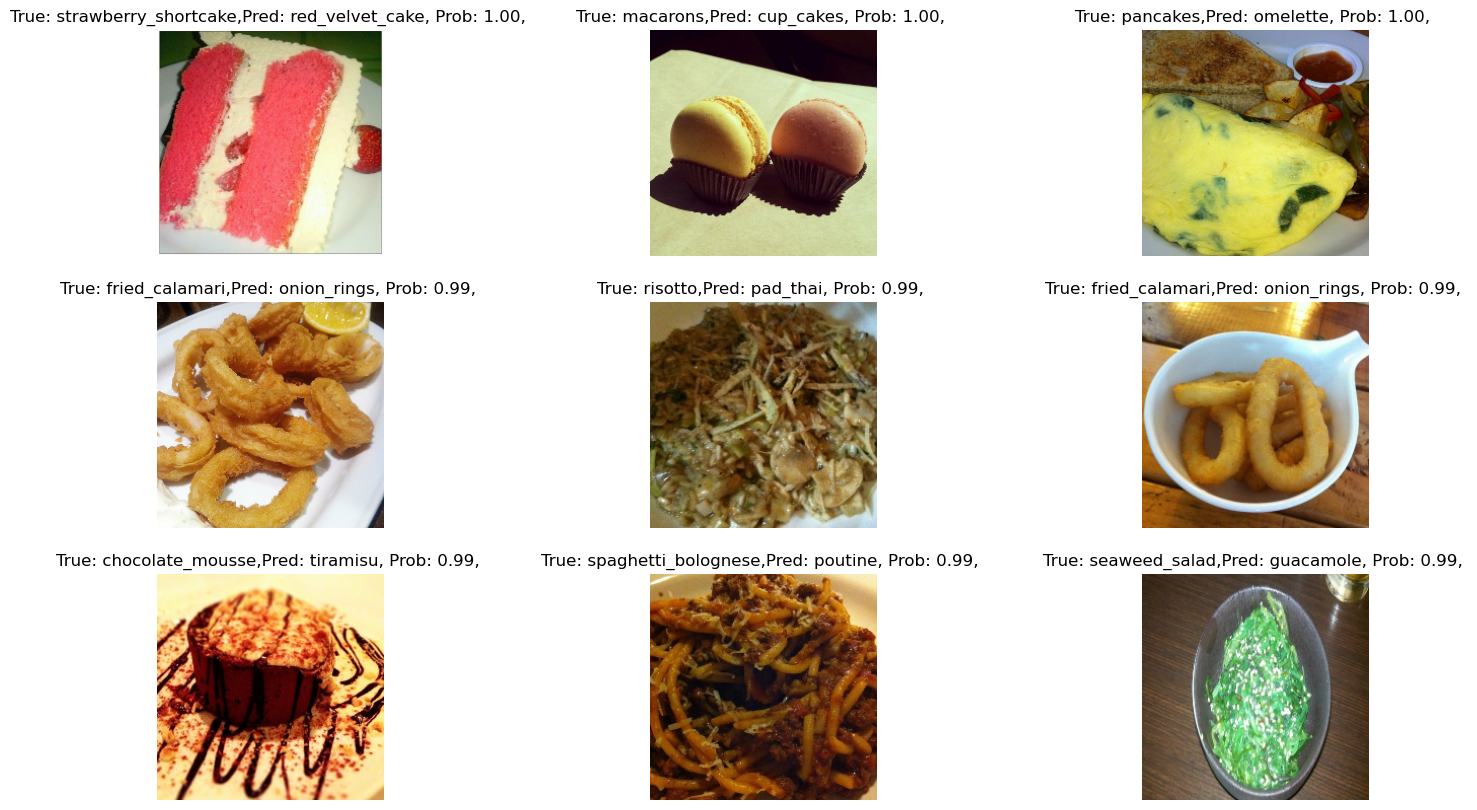

In [132]:
plt.figure(figsize=(18,10))
for i,row in enumerate(top_100_wrong[:10].itertuples()):
    print(f"row:{row}")
    plt.subplot(3,3,i+1)
    img = load_and_prep_image(row[1],scale=True)
    _, _, _, _, pred_prob, y_true, y_pred, _ = row
    plt.imshow(img)
    plt.title(f"True: {y_true},Pred: {y_pred}, Prob: {pred_prob:.2f}, ")
    plt.axis(False)

Going through the model's most wrong predictions can usually help figure out a couple of things:

1、某些图片的标签就是错的，或者说都可以，2、针对这些容易犯错的图片，可以搜集更多的数据，

* **Some of the labels might be wrong** - If our model ends up being good enough, it may actually learning to predict very well on certain classes. This means some images which the model predicts the right label may show up as wrong if the ground truth label is wrong. If this is the case, we can often use our model to help us improve the labels in our dataset(s) and in turn, potentially making future models better. This process of using the model to help improve labels is often referred to as [**active learning**](https://blog.scaleway.com/active-learning-some-datapoints-are-more-equal-than-others/).
* **Could more samples be collected?** - If there's a recurring pattern for a certain class being poorly predicted on, perhaps it's a good idea to collect more samples of that particular class in different scenarios to improve further models.

## Test out the big dog model on test images as well as custom images of food 

So far we've visualized some our model's predictions from the test dataset but it's time for the real test: using our model to make predictions on our own custom images of food.

For this you might want to upload your own images to Google Colab or by putting them in a folder you can load into the notebook.

In my case, I've prepared my own small dataset of six or so images of various foods.

Let's download them and unzip them.

In [82]:
if not os.path.exists("food_vision/custom_food_images.zip"):
    !wget https://storage.googleapis.com/ztm_tf_course/food_vision/custom_food_images.zip
if not os.path.exists("food_vision/custom_food_images"):
    unzip_data("custom_food_images.zip") 

--2025-01-14 15:33:22--  https://storage.googleapis.com/ztm_tf_course/food_vision/custom_food_images.zip
Resolving storage.googleapis.com (storage.googleapis.com)... 142.251.33.91, 142.251.211.251, 142.251.33.123, ...
Connecting to storage.googleapis.com (storage.googleapis.com)|142.251.33.91|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 13192985 (13M) [application/zip]
Saving to: ‘custom_food_images.zip’

custom_food_images. 100%[===================>]  12.58M  5.51MB/s    in 2.3s    

2025-01-14 15:33:26 (5.51 MB/s) - ‘custom_food_images.zip’ saved [13192985/13192985]



In [83]:
custom_food_images = ["custom_food_images/" + img_path for img_path in os.listdir("custom_food_images")]
custom_food_images

['custom_food_images/hamburger.jpeg',
 'custom_food_images/chicken_wings.jpeg',
 'custom_food_images/sushi.jpeg',
 'custom_food_images/steak.jpeg',
 'custom_food_images/ramen.jpeg',
 'custom_food_images/pizza-dad.jpeg']

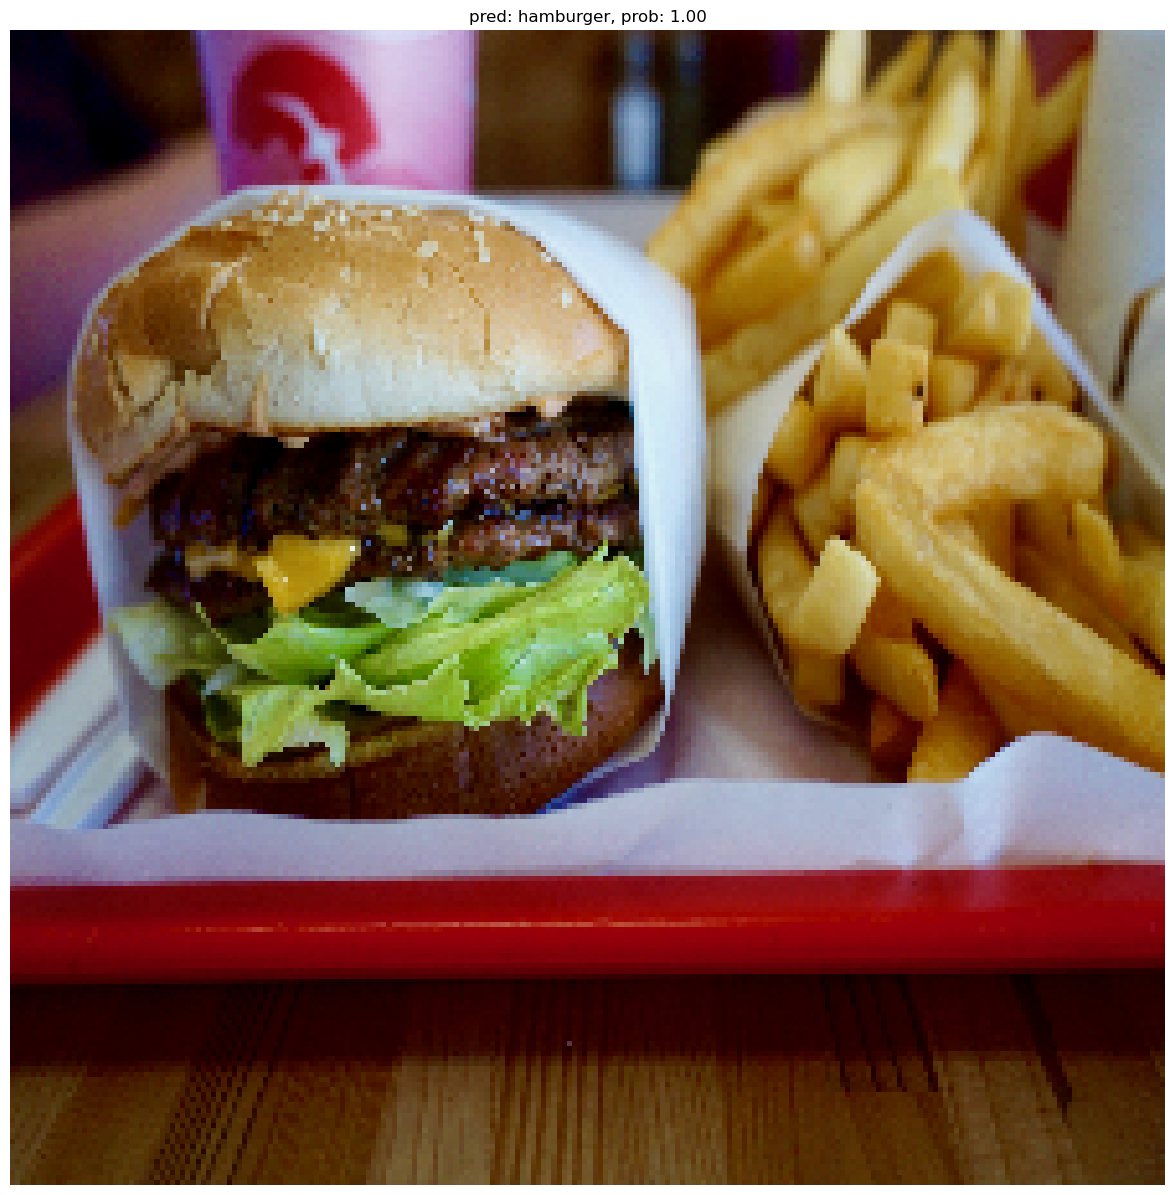

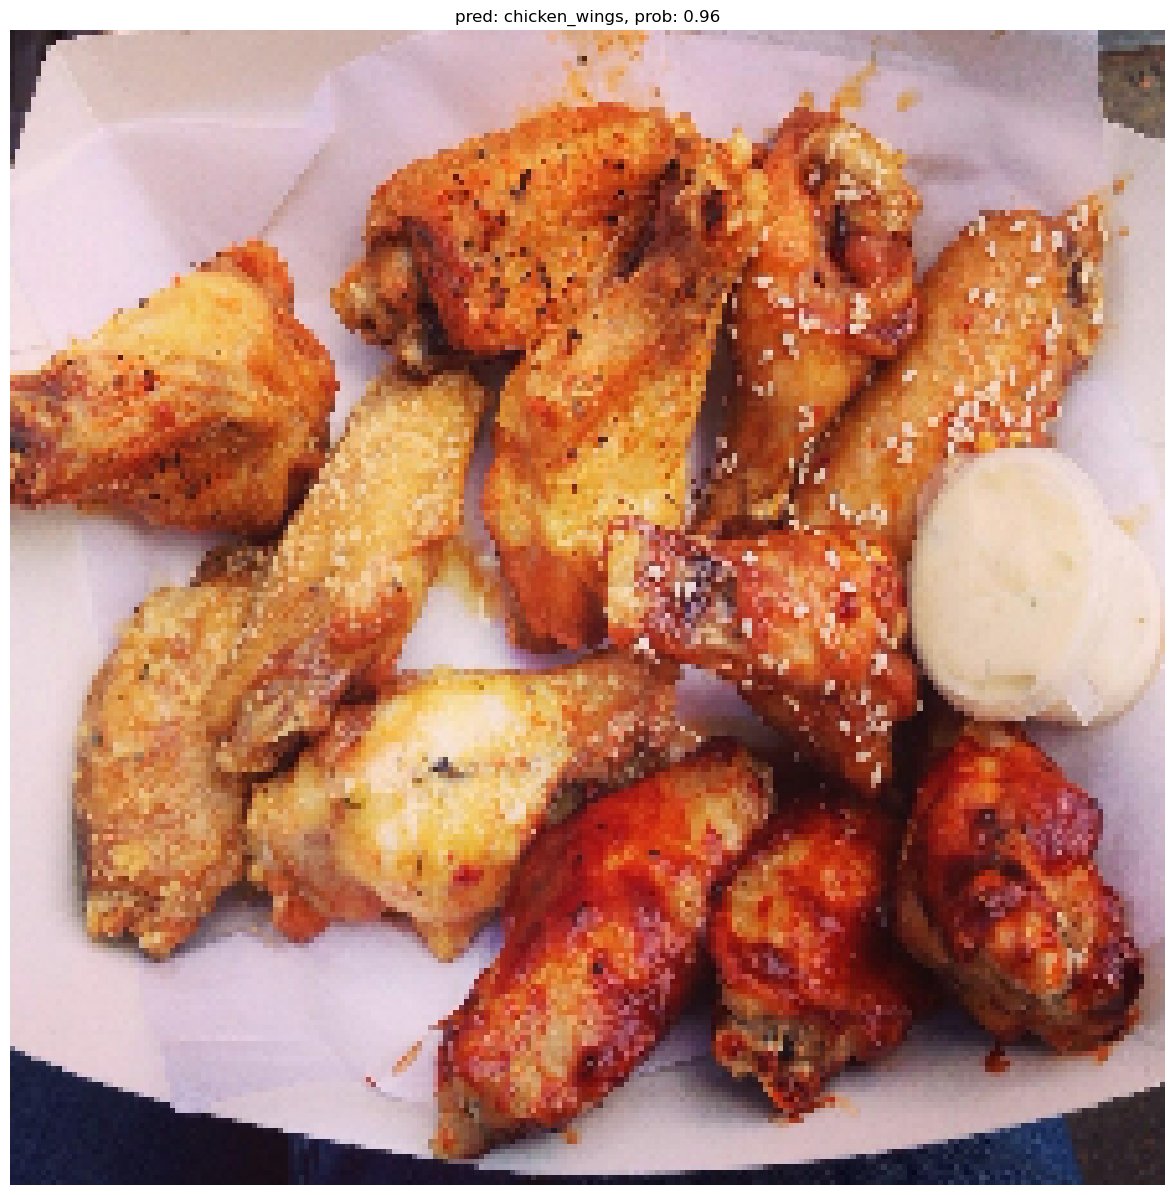

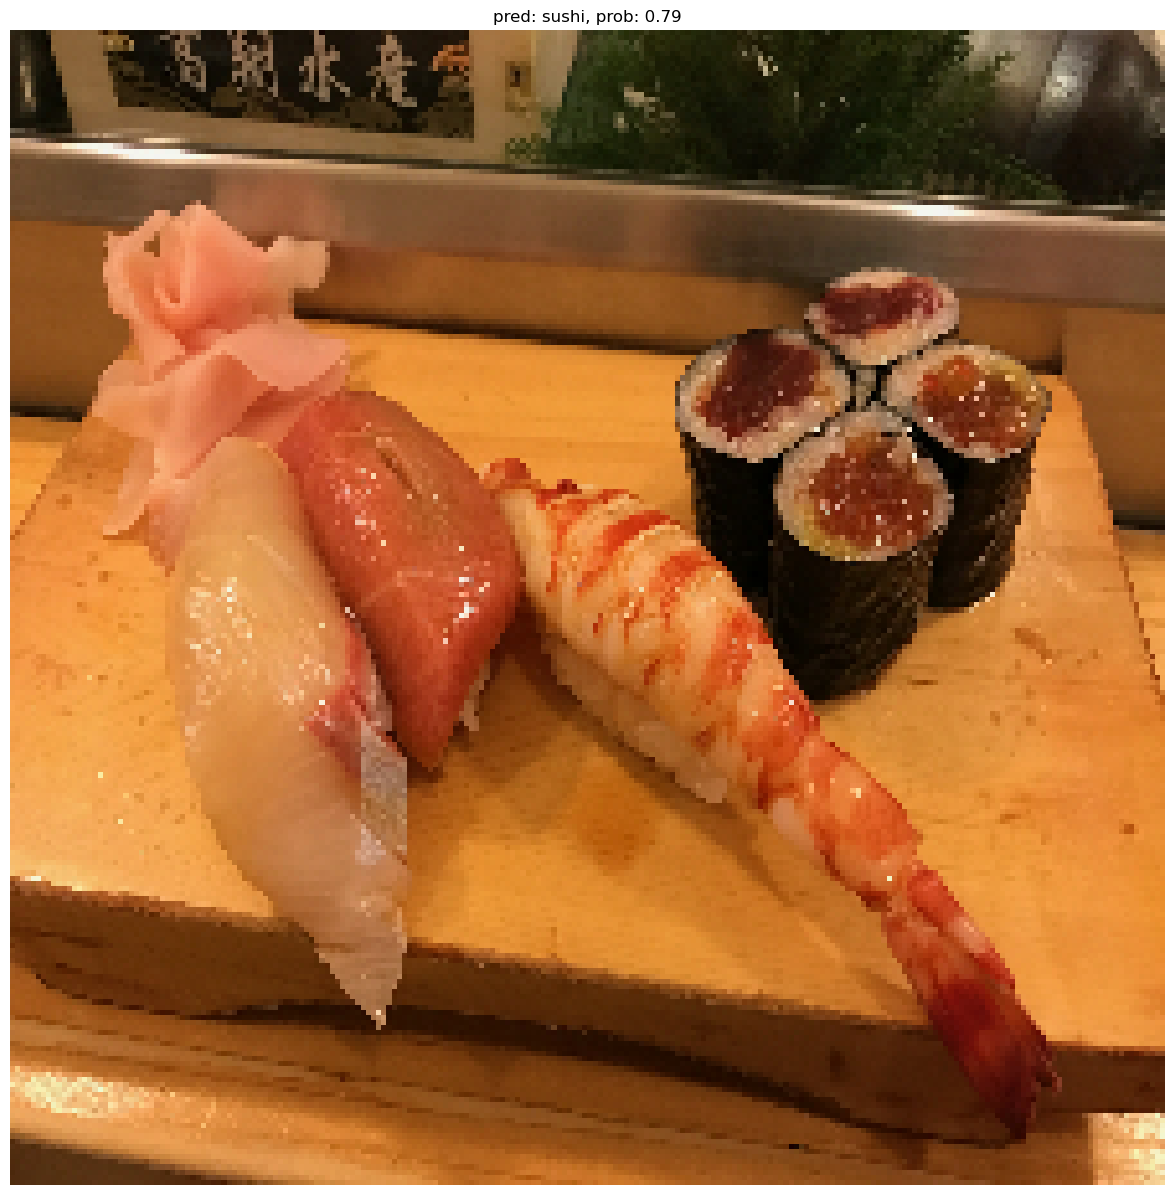

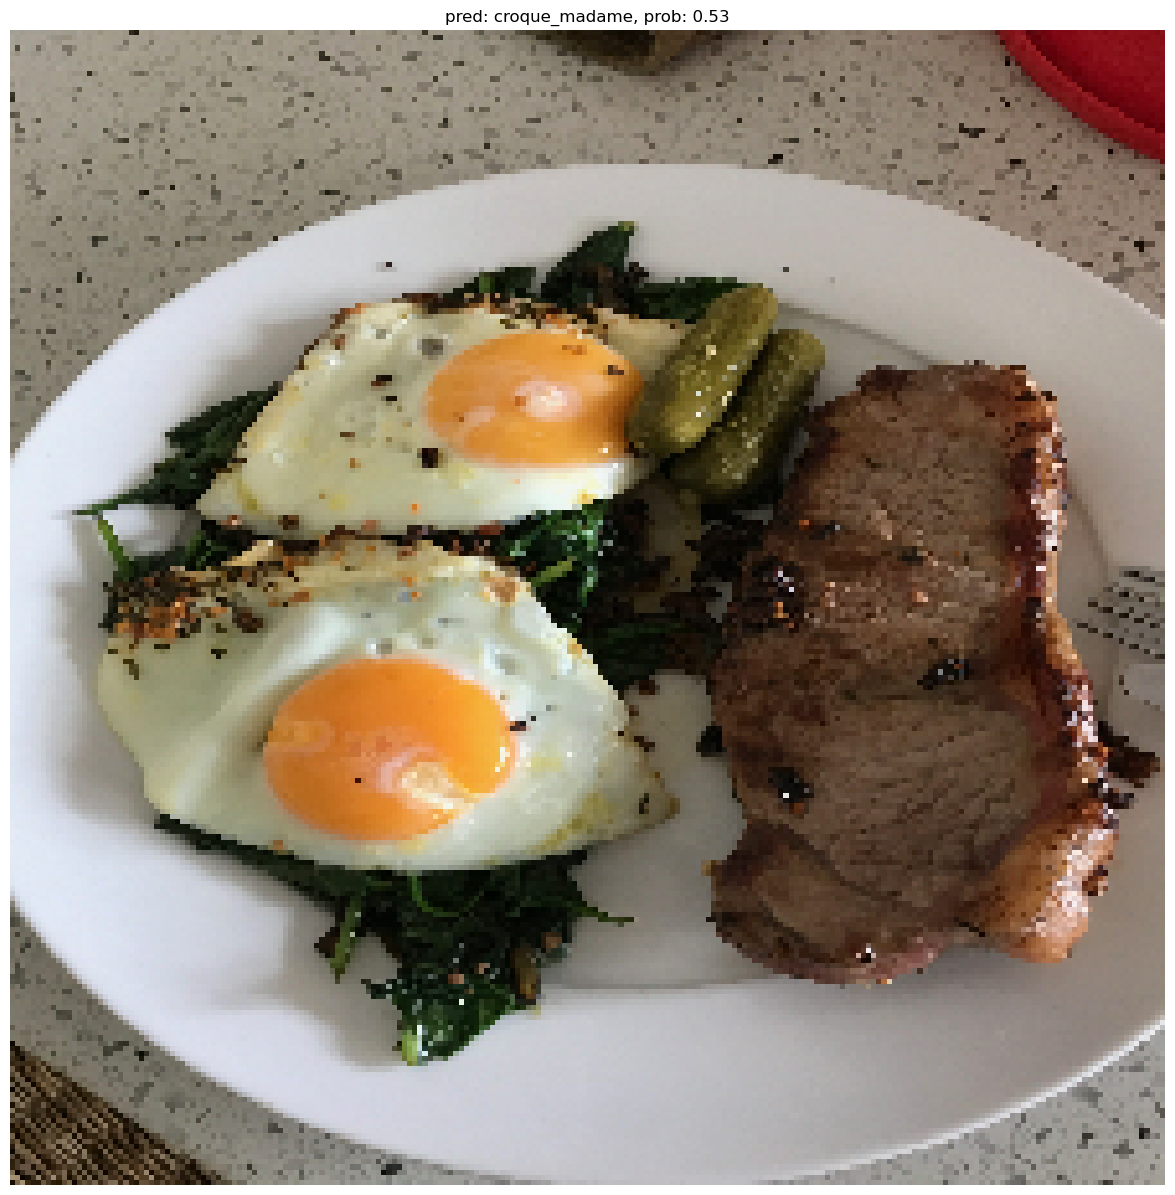

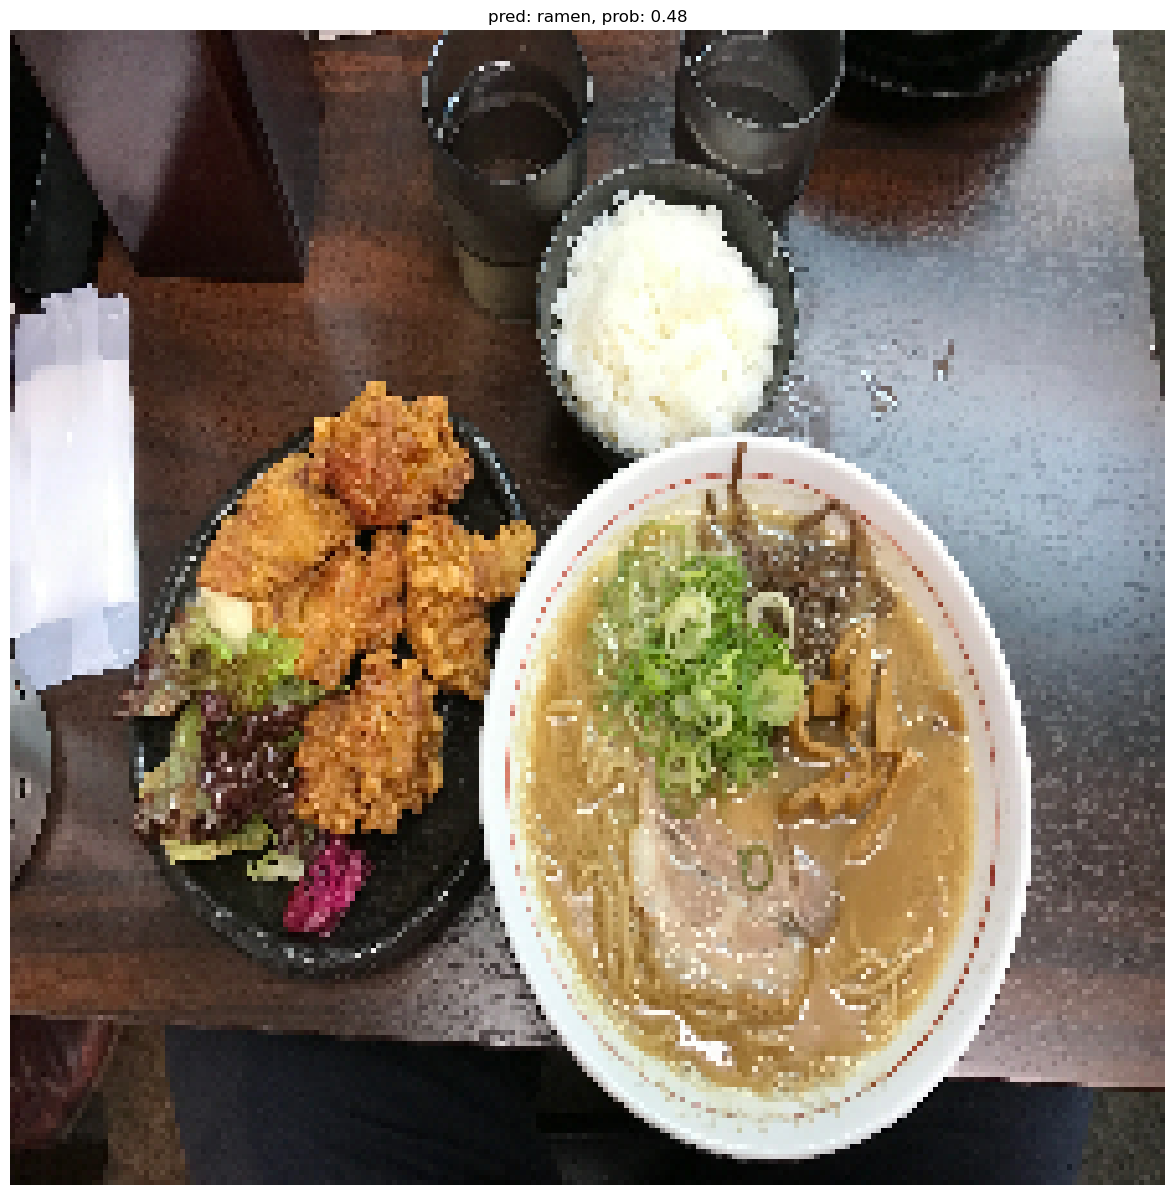

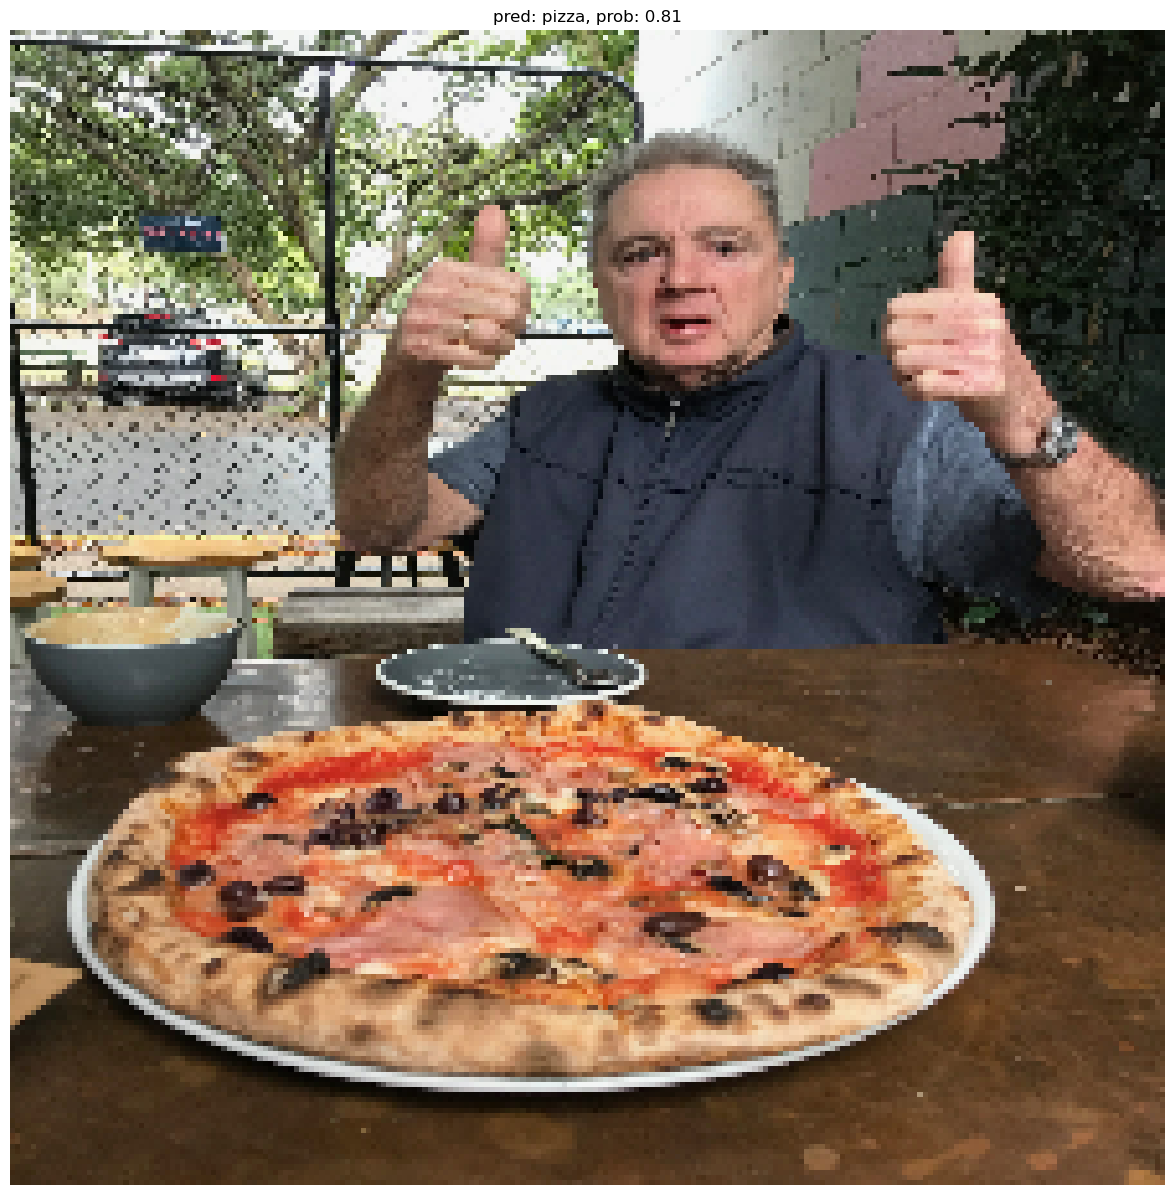

In [84]:
for imgpath in custom_food_images:
    img = load_and_prep_image(imgpath,scale=False)
    pred_prob = model.predict(tf.expand_dims(img, axis=0)) #prediction on image with shape [None, 224, 224, 3],添加批次的维度
    pred_class = class_names[pred_prob.argmax()]
    plt.figure(figsize=(10,8))
    plt.imshow(img/255.)
    plt.title(f"pred: {pred_class}, prob: {pred_prob.max():.2f}")
    plt.axis(False)

And guess what... our model got these incredible results (10%+ better than the baseline) with only 10% of the training images.

I wonder what would happen if we trained a model with all of the data (100% of the training data from Food101 instead of 10%)? Hint: that's your task in the next notebook.

10%的训练数据，模型性能提升10%以上。

## 🛠 Exercises

1. Take 3 of your own photos of food and use the trained model to make predictions on them, share your predictions with the other students in Discord and show off your Food Vision model 🍔👁.
2. Train a feature-extraction transfer learning model for 10 epochs on the same data and compare its performance versus a model which used feature extraction for 5 epochs and fine-tuning for 5 epochs (like we've used in this notebook). Which method is better?
3. Recreate our first model (the feature extraction model) with [`mixed_precision`](https://www.tensorflow.org/guide/mixed_precision) turned on. 使用混合精度
  * Does it make the model train faster? 
  * Does it effect the accuracy or performance of our model? 
  * What's the advatanges of using `mixed_precision` training?

## 📖 Extra-curriculum

早停机制，测试集的指标不下降的时候，可以早停，防止过拟合

Streamlit 快速构建Web 应用程序，类似的还有Gradio，非常适合大模型的交互页面的搭建

* Spend 15-minutes reading up on the [EarlyStopping callback](https://www.tensorflow.org/api_docs/python/tf/keras/callbacks/EarlyStopping). What does it do? How could we use it in our model training?  
* Spend an hour reading about [Streamlit](https://www.streamlit.io/). What does it do? How might you integrate some of the things we've done in this notebook in a Streamlit app?